<a href="https://colab.research.google.com/github/francescodalmonte/Computer-Vision-miscellanea/blob/main/Faster_RCNN_regioni_tele.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Dependencies and runtime settings

In [1]:
import os
import time
import copy
import pickle
import numpy as np
from PIL import Image
import cv2 as cv
from matplotlib import pyplot as plt

import torch
import torch.optim as optim

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import tv_tensors
from torchvision.transforms import v2 as T2
from torchvision.utils import draw_bounding_boxes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Load Data and define the custom Dataset class

In [2]:
# load data to local memory
start = time.time()
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/My Drive/Colab_Notebooks/progetto_AML/CABE_15112023_XL.zip" "CABE_15112023_XL.zip"
!unzip --qq CABE_15112023_XL.zip

print(f"Took {(time.time()-start):.3f} s")

Mounted at /content/drive
Took 119.553 s


In [3]:
# custom dataset class

class ClothsDataset(torch.utils.data.Dataset):
    """Custom class for cloths images + labelling dataset

    """

    def __init__(self, dir_path: str, is_train: bool, size: list[int,] = None):
        self.dir_path = dir_path
        self.is_train = is_train
        self.size = size
        self.aspratio = self.size[0]/self.size[1]
        self.imgs_path = sorted([os.path.join(dir_path, f+"/VistaAcq001_002.bmp")
                                 for f in os.listdir(dir_path) if f.endswith(".obj")])
        self.labels_path = sorted([os.path.join(dir_path, f)
                                   for f in os.listdir(dir_path) if f.endswith(".txt")])

        # set_transforms
        if self.is_train:
            self.transform = T2.Compose([T2.Normalize(mean=[87.3, 87.3, 87.3],
                                                      std=[40., 40., 40.]),
                                         T2.RandomHorizontalFlip(p=0.4),
                                         T2.RandomVerticalFlip(p=0.4),
                                         T2.RandomResizedCrop([self.size[1],self.size[0]],
                                                              scale=(0.5, 1.0),
                                                              ratio=(self.aspratio*0.9, self.aspratio*1.1),
                                                              antialias=True),
                                         T2.ClampBoundingBoxes(),
                                         T2.SanitizeBoundingBoxes(min_size = 1.0)
                                         ])
        else:
            self.transform = T2.Compose([T2.Normalize(mean=[87.3, 87.3, 87.3],
                                                      std=[40., 40., 40.])
                                         ])



    def read_img(self, img_path):
        """Read an image from file and resize it (returns a tv_tensors.Image
        object).

        """
        img = Image.open(img_path).convert('RGB')
        if self.size is not None:
            img =  img.resize(self.size, resample = Image.Resampling.LANCZOS)
        img = tv_tensors.Image(img, dtype=torch.float)
        return img



    def read_labels(self, labels_path):
        """Read image labels from file (returns lists of ints and of
        tv_tensors.BoundingBoxes objects).

        """
        W, H = self.size
        ys, bboxes = [], []
        with open(labels_path) as file:
            for l in file.readlines():
                y, cx, cy, w, h = l.split(" ")
                bbox = [np.rint(float(cx)*W), np.rint(float(cy)*H),
                        np.rint(float(w)*W), np.rint(float(h)*H)]

                ys.append(int(y)+1)
                bboxes.append(bbox)
        bboxes = tv_tensors.BoundingBoxes(bboxes,
                                          canvas_size = [self.size[1], self.size[0]],
                                          format = "CXCYWH",
                                          dtype=torch.int)
        bboxes = T2.ConvertBoundingBoxFormat("XYXY")(bboxes)
        ys = torch.tensor(ys)

        return ys, bboxes



    def __getitem__(self, idx):
        x = self.read_img(self.imgs_path[idx])
        ys, bboxes = self.read_labels(self.labels_path[idx])

        target = {"boxes": bboxes, "labels": ys}
        x, target = self.transform(x, target)

        return x, target



    def __len__(self):
        return len(self.imgs_path)

In [4]:
def collate_fn(data):
    return tuple(zip(*data))

In [5]:
def show_examples(images, targets, N=5):

    cmapping = {"1":"tab:green", "2":"tab:orange"}
    N = np.min([N, len(images)])

    fig, ax = plt.subplots(nrows=1, ncols=N, tight_layout=True)
    for i, a in enumerate(ax):
        im = (images[i]*40. + 128.).to(torch.uint8)
        bb = T2.ConvertBoundingBoxFormat("XYWH")(targets[i]["boxes"])

        a.imshow(np.transpose(im, (1,2,0)))
        if i>0:
            a.set_yticks([])
        for lab, box in zip(targets[i]["labels"], bb):
            a.add_patch(plt.Rectangle((box[0], box[1]), box[2], box[3],
                                    facecolor=cmapping[str(lab.numpy())], lw=1, alpha=0.5))
            a.text(s=lab.numpy(), x=box[0], y=box[1], fontsize=6, verticalalignment="top")

## 2. Faster RCNN model definition

In [6]:
def get_fasterRCNN_model(num_classes: int = 3):

    # get pre-trained model
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # replace head with a new one
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

## 3. Training functions

In [7]:
def train(model,
          dataloader,
          device,
          optimizer,
          log_interval):
    """Trains a neural network for one epoch.
    """
    start = time.time()

    model.train()

    n_samples_super = 0
    loss_class_super = 0
    loss_box_reg_super = 0
    loss_obj_super = 0
    loss_rpn_super = 0
    loss_tot_super = 0

    for idx_batch, (inputs, targets) in enumerate(dataloader):
        optimizer.zero_grad()

        # forward pass
        inputs = list(input.to(device) for input in inputs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(inputs, targets)

        n_samples = len(inputs)
        loss_class = loss_dict['loss_classifier']
        loss_box_reg = loss_dict['loss_box_reg']
        loss_obj = loss_dict['loss_objectness']
        loss_rpn = loss_dict['loss_rpn_box_reg']
        loss_tot = sum([l for l in loss_dict.values()])

        # backward pass
        loss_tot.backward()
        optimizer.step()

        # log and store current values
        n_samples_super += n_samples
        loss_class_super += loss_class.cpu().detach()
        loss_box_reg_super += loss_box_reg.cpu().detach()
        loss_obj_super += loss_obj.cpu().detach()
        loss_rpn_super += loss_rpn.cpu().detach()
        loss_tot_super += loss_tot.cpu().detach()

        if log_interval>0:
            if idx_batch%log_interval==0:
                print(f"TRAIN batch {idx_batch}/{len(dataloader)} - loss: {(loss_tot):.5f}", end=" - ")
                print(f"elapsed time: {(time.time()-start):.3f} s")

    dict_losses = {'classification': loss_class_super/n_samples_super,
                   'bbox_regression': loss_box_reg_super/n_samples_super,
                   'objectness': loss_obj_super/n_samples_super,
                   'rpn': loss_rpn_super/n_samples_super,
                   'sum': loss_tot_super/n_samples_super
                  }
    return dict_losses

In [15]:
def validate(model,
             dataloader,
             device):
    """Perform one validation step.
    """

    n_samples_super = 0
    loss_class_super = 0
    loss_box_reg_super = 0
    loss_obj_super = 0
    loss_rpn_super = 0
    loss_tot_super = 0

    with torch.no_grad():
        for idx_batch, (inputs, targets) in enumerate(dataloader):

            # forward pass
            inputs = list(input.to(device) for input in inputs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(inputs, targets)

            n_samples = len(inputs)
            loss_class = loss_dict['loss_classifier']
            loss_box_reg = loss_dict['loss_box_reg']
            loss_obj = loss_dict['loss_objectness']
            loss_rpn = loss_dict['loss_rpn_box_reg']
            loss_tot = sum([l for l in loss_dict.values()])

            # log and store current values
            n_samples_super += n_samples
            loss_class_super += loss_class.cpu().detach()
            loss_box_reg_super += loss_box_reg.cpu().detach()
            loss_obj_super += loss_obj.cpu().detach()
            loss_rpn_super += loss_rpn.cpu().detach()
            loss_tot_super += loss_tot.cpu().detach()

    dict_losses = {'classification': loss_class_super/n_samples_super,
                   'bbox_regression': loss_box_reg_super/n_samples_super,
                   'objectness': loss_obj_super/n_samples_super,
                   'rpn': loss_rpn_super/n_samples_super,
                   'sum': loss_tot_super/n_samples_super
                  }
    return dict_losses

In [9]:
def training_loop(num_epochs,
                  optimizer,
                  model,
                  loader_train,
                  loader_val,
                  name_train,
                  log_interval=-1,
                  lr_scheduler=None,
                  verbose=True):
    """Executes the training loop.
    """

    if not os.path.exists('checkpoints'):
        os.makedirs('checkpoints')

    losses_train_class = []
    losses_train_box_reg = []
    losses_train_obj = []
    losses_train_rpn = []
    losses_train_tot = []

    losses_val_class = []
    losses_val_box_reg = []
    losses_val_obj = []
    losses_val_rpn = []
    losses_val_tot = []

    best_val = np.inf

    for epoch in range(1, num_epochs + 1):
        start=time.time()

        # train step
        loss_dict_train = train(model,
                                loader_train,
                                device,
                                optimizer,
                                log_interval)


        # val step
        loss_dict_val = validate(model,
                                 loader_val,
                                 device)

        # store results
        losses_train_class.append(loss_dict_train["classification"])
        losses_train_box_reg.append(loss_dict_train["bbox_regression"])
        losses_train_obj.append(loss_dict_train["objectness"])
        losses_train_rpn.append(loss_dict_train["rpn"])
        losses_train_tot.append(loss_dict_train["sum"])

        losses_val_class.append(loss_dict_val["classification"])
        losses_val_box_reg.append(loss_dict_val["bbox_regression"])
        losses_val_obj.append(loss_dict_val["objectness"])
        losses_val_rpn.append(loss_dict_val["rpn"])
        losses_val_tot.append(loss_dict_val["sum"])

        lr = optimizer.param_groups[0]['lr']

        # save checkpoint if performances improved on val set
        if loss_dict_val['sum'] < best_val:
            best_val = loss_dict_val['sum']
            torch.save(model.state_dict(), f"checkpoints/{name_train}.ckpt")
            msg = " (**ckpt)"
        else:
            msg = " "

        # scheduler step
        if lr_scheduler is not None:
            lr_scheduler.step()

        if verbose:
            print(f"Epoch: {epoch} - TRAIN loss: {loss_dict_train['sum']:.6f} - VAL loss: {loss_dict_val['sum']:.6f}", end=" - ")
            print(f"elapsed time: {(time.time()-start):.3f} s  {msg}")


    return {"train": {'classification': losses_train_class,
                      'bbox_regression': losses_train_box_reg,
                      'objectness': losses_train_obj,
                      'rpn': losses_train_rpn,
                      'sum': losses_train_tot,
                      },
            "val": {'classification': losses_val_class,
                    'bbox_regression': losses_val_box_reg,
                    'objectness': losses_val_obj,
                    'rpn': losses_val_rpn,
                    'sum': losses_val_tot,
                    }
            }

In [10]:
def execute(name_train,
            num_epochs,
            optimizer,
            lr_scheduler,
            model,
            data_loader_train,
            data_loader_val,
            log_interval):
    """Executes the training loop and save results to file.
    """

    # launch training
    dict_results = training_loop(num_epochs,
                                 optimizer,
                                 model,
                                 data_loader_train,
                                 data_loader_val,
                                 name_train,
                                 log_interval,
                                 lr_scheduler=lr_scheduler,
                                 verbose=True)


    # save results
    if not os.path.exists('train_info'):
        os.makedirs('train_info')

    with open(f"train_info/{name_train}-train_losses.pkl", "wb") as f:
        pickle.dump(dict_results["train"], f)
    with open(f"train_info/{name_train}-val_losses.pkl", "wb") as f:
        pickle.dump(dict_results["val"], f)

## 4. Main

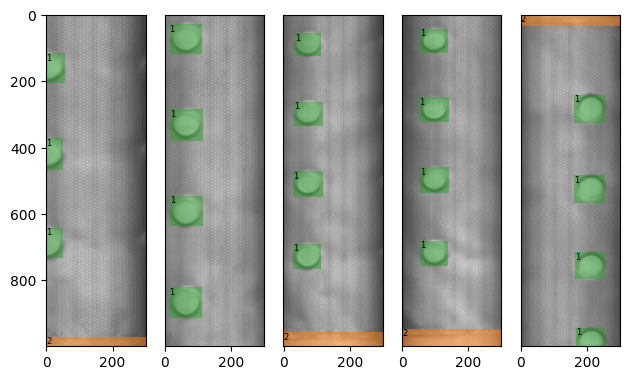

In [11]:
# datasets and dataloaders

ds = ClothsDataset("CABE_15112023_XL", is_train = True, size = [300, 1000])

nval = int(len(ds) * 0.2)
ds_train, ds_val = torch.utils.data.random_split(ds, [len(ds)-nval, nval])

dl_train = torch.utils.data.DataLoader(ds_train,
                                       batch_size=5,
                                       shuffle=True,
                                       num_workers=0,
                                       collate_fn=collate_fn,
                                       )
dl_val = torch.utils.data.DataLoader(ds_train,
                                     batch_size=5,
                                     shuffle=False,
                                     num_workers=0,
                                     collate_fn=collate_fn
                                     )

images, targets = next(iter(dl_train))
show_examples(images, targets, N=5)

In [12]:
# model
model = get_fasterRCNN_model(num_classes=3)
_ = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]


# optimizer
optimizer = optim.SGD(params,
                      lr = 0.01,
                      momentum = 0.9,
                      weight_decay = 0.0005)


# Learning Rate scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,60,90], gamma=0.15)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 129MB/s]


## 5. Execution

In [13]:
name = "Faster-RCNN"
n_epochs = 25

In [16]:
execute(name,
        n_epochs,
        optimizer,
        scheduler,
        model,
        dl_train, dl_val,
        log_interval=-1)

Epoch: 1 - TRAIN loss: 0.345776 - VAL loss: 0.102482 - elapsed time: 38.175 s   (**ckpt)
Epoch: 2 - TRAIN loss: 0.153097 - VAL loss: 0.133108 - elapsed time: 35.165 s   
Epoch: 3 - TRAIN loss: 0.103760 - VAL loss: 0.144994 - elapsed time: 39.224 s   
Epoch: 4 - TRAIN loss: 0.129798 - VAL loss: 0.079656 - elapsed time: 45.290 s   (**ckpt)
Epoch: 5 - TRAIN loss: 0.084918 - VAL loss: 0.098511 - elapsed time: 38.147 s   
Epoch: 6 - TRAIN loss: 0.093665 - VAL loss: 0.093962 - elapsed time: 35.613 s   
Epoch: 7 - TRAIN loss: 0.092120 - VAL loss: 0.067623 - elapsed time: 36.415 s   (**ckpt)
Epoch: 8 - TRAIN loss: 0.066280 - VAL loss: 0.080744 - elapsed time: 36.937 s   
Epoch: 9 - TRAIN loss: 0.057223 - VAL loss: 0.060216 - elapsed time: 36.487 s   (**ckpt)
Epoch: 10 - TRAIN loss: 0.055697 - VAL loss: 0.064259 - elapsed time: 36.080 s   
Epoch: 11 - TRAIN loss: 0.057417 - VAL loss: 0.051206 - elapsed time: 35.691 s   (**ckpt)
Epoch: 12 - TRAIN loss: 0.051436 - VAL loss: 0.055375 - elapsed tim

## 5. Visualize results

In [17]:
#if not os.path.exists('checkpoints'):
#    os.makedirs('checkpoints')
#if not os.path.exists('train_info'):
#    os.makedirs('train_info')

# upload data if needed
#!cp "/content/drive/My Drive/Colab_Notebooks/progetto_AML/Faster-RCNN-train_losses.pkl" "train_info/Faster-RCNN-train_losses.pkl"
#!cp "/content/drive/My Drive/Colab_Notebooks/progetto_AML/Faster-RCNN-val_losses.pkl" "train_info/Faster-RCNN-val_losses.pkl"
#!cp "/content/drive/My Drive/Colab_Notebooks/progetto_AML/Faster-RCNN.ckpt" "checkpoints/Faster-RCNN.ckpt"

In [18]:
def plot_losses(ax, train_loss, val_loss, title):
    plot1, = ax.plot(train_loss, color="tab:blue", label="train")
    plot2, = ax.plot(val_loss, color="tab:orange", label="val")
    ax.legend(handles=[plot1, plot2])
    ax.set_xlabel("epochs")
    ax.set_ylabel("loss")
    ax.set_title(title)

def train_plots(dirpath, name_train):
    with open(os.path.join(dirpath, f"{name_train}-train_losses.pkl"), "rb") as f:
        train_losses_dict = pickle.load(f)
    with open(os.path.join(dirpath, f"{name_train}-val_losses.pkl"), "rb") as f:
        val_losses_dict = pickle.load(f)

    keys = train_losses_dict.keys()
    assert keys==val_losses_dict.keys()

    fig, ax = plt.subplots(nrows=1, ncols=len(keys), tight_layout=True, figsize=(2.5*len(keys), 2.5))
    for i, k in enumerate(keys):
        plot_losses(ax[i], train_losses_dict[k], val_losses_dict[k], title=k)

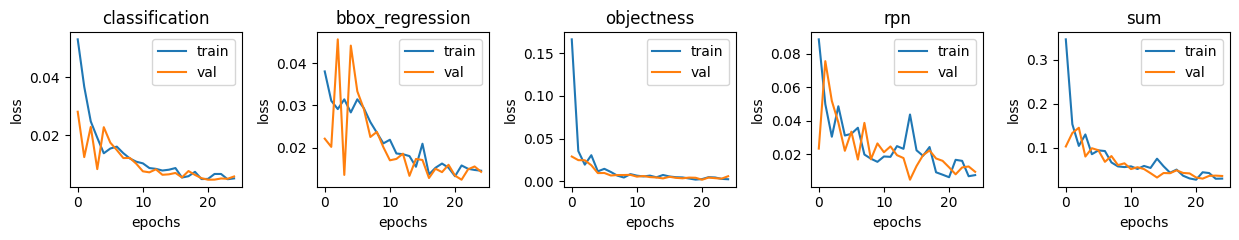

In [19]:
train_plots("train_info", name)

In [26]:
def predict(trained_model, images, targets, device):
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    model.eval()
    output = model(images, targets)
    return output


def show_predictions(images, targets, outputs, threshold=0.01, N=5):
    N = np.min([N, len(images)])

    cmapping = {"1": "green", "2": "red"}
    fig, ax = plt.subplots(nrows=1, ncols=N, figsize=(2*N, 6), tight_layout=True)
    for i, (im, t, out) in enumerate(zip(images[:N], targets[:N], outputs[:N])):
        im = (im*40 + 128).to(torch.uint8)
        thmask = out["scores"]>threshold
        boxes = out["boxes"][thmask]
        colors = [cmapping[str(l.cpu().numpy())] for l in out["labels"][thmask]]
        description = [f"{s:.3f}" for s in out["scores"][thmask]]

        result = draw_bounding_boxes(im, boxes, labels=description, colors=colors,
                                     width=4, font="LiberationSerif-Regular.ttf", font_size=30)

        ax[i].imshow(np.transpose(result, (1,2,0)))

In [21]:
images, targets = next(iter(dl_val))
model.load_state_dict(torch.load(f"checkpoints/{name}.ckpt"))

<All keys matched successfully>

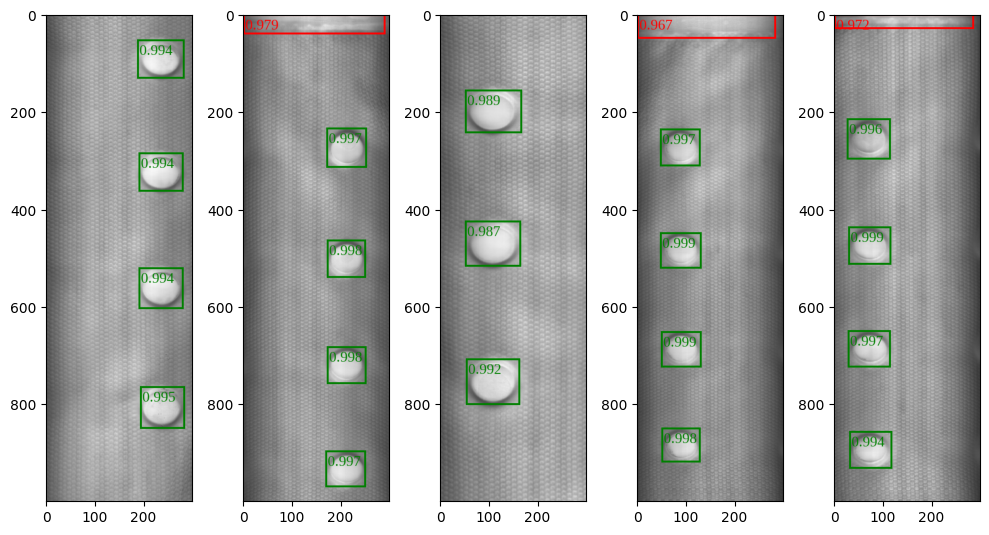

In [27]:
outputs = predict(model, images, targets, device)
show_predictions(images, targets, outputs, threshold=0.8)